*Accompanying code examples of the book "Introduction to Artificial Neural Networks and Deep Learning: A Practical Guide with Applications in Python" by [Sebastian Raschka](https://sebastianraschka.com). All code examples are released under the [MIT license](https://github.com/rasbt/deep-learning-book/blob/master/LICENSE). If you find this content useful, please consider supporting the work by buying a [copy of the book](https://leanpub.com/ann-and-deeplearning).*
  
Other code examples and content are available on [GitHub](https://github.com/rasbt/deep-learning-book). The PDF and ebook versions of the book are available through [Leanpub](https://leanpub.com/ann-and-deeplearning).

In [1]:
#load watermark
%load_ext watermark
%watermark -a 'Gopala KR' -u -d -v -p watermark,numpy,matplotlib,nltk,sklearn,tensorflow,theano,mxnet,chainer,seaborn,keras,tflearn,bokeh,gensim

/srv/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Using TensorFlow backend.
/srv/venv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Gopala KR 
last updated: 2018-02-28 

CPython 3.6.3
IPython 6.2.1

watermark 1.6.0
numpy 1.14.1
matplotlib 2.1.2
nltk 3.2.5
sklearn 0.19.1
tensorflow 1.5.0
theano 1.0.1
mxnet 1.1.0
chainer 3.4.0
seaborn 0.8.1
keras 2.1.4
tflearn n
bokeh 0.12.14
gensim 3.3.0


/srv/venv/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


# Model Zoo -- Logistic Regression

Implementation of *classic* logistic regression for binary class labels.

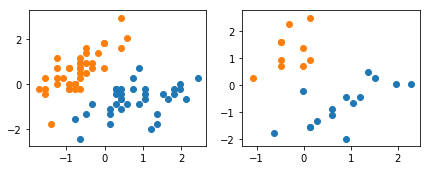

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO

##########################
### DATASET
##########################

ds = np.lib.DataSource()
fp = ds.open('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')

x = np.genfromtxt(BytesIO(fp.read().encode()), delimiter=',', usecols=range(2), max_rows=100)
y = np.zeros(100)
y[50:] = 1

np.random.seed(1)
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
x_test, y_test = x[idx[:25]], y[idx[:25]]
x_train, y_train = x[idx[25:]], y[idx[25:]]
mu, std = np.mean(x_train, axis=0), np.std(x_train, axis=0)
x_train, x_test = (x_train - mu) / std, (x_test - mu) / std

fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))
ax[0].scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1])
ax[0].scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1])
ax[1].scatter(x_test[y_test == 1, 0], x_test[y_test == 1, 1])
ax[1].scatter(x_test[y_test == 0, 0], x_test[y_test == 0, 1])
plt.show()

In [3]:
##########################
### HELPER FUNCTIONS
##########################

def iterate_minibatches(arrays, batch_size, shuffle=False, seed=None):
    rgen = np.random.RandomState(seed)
    indices = np.arange(arrays[0].shape[0])

    if shuffle:
        rgen.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - batch_size + 1, batch_size):
        index_slice = indices[start_idx:start_idx + batch_size]

        yield (ary[index_slice] for ary in arrays)

In [4]:
import tensorflow as tf


##########################
### SETTINGS
##########################

n_features = x.shape[1]
n_samples = x.shape[0]
learning_rate = 0.05
training_epochs = 15
batch_size = 10


##########################
### GRAPH DEFINITION
##########################

g = tf.Graph()
with g.as_default() as g:

   # Input data
    tf_x = tf.placeholder(dtype=tf.float32,
                          shape=[None, n_features], name='inputs')
    tf_y = tf.placeholder(dtype=tf.float32,
                          shape=[None], name='targets')
    
    # Model parameters
    params = {
        'weights': tf.Variable(tf.zeros(shape=[n_features, 1],
                                               dtype=tf.float32), name='weights'),
        'bias': tf.Variable([[0.]], dtype=tf.float32, name='bias')}

    # Logistic Regression
    linear = tf.matmul(tf_x, params['weights']) + params['bias']
    pred_proba = tf.sigmoid(linear, name='predict_probas')

    # Loss and optimizer
    r = tf.reshape(pred_proba, [-1])
    cost = tf.reduce_mean(tf.reduce_sum((-tf_y * tf.log(r)) - 
                                        ((1. - tf_y) * tf.log(1. - r))), name='cost')
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train = optimizer.minimize(cost, name='train')
                                                  
    # Class prediction
    pred_labels = tf.round(tf.reshape(pred_proba, [-1]), name='predict_labels')
    correct_prediction = tf.equal(tf_y, pred_labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')


##########################
### TRAINING & EVALUATION
##########################
    
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    
    avg_cost = np.nan
    count = 1
    
    for epoch in range(training_epochs):

        train_acc = sess.run('accuracy:0', feed_dict={tf_x: x_train,
                                                      tf_y: y_train})
        valid_acc = sess.run('accuracy:0', feed_dict={tf_x: x_test,
                                                      tf_y: y_test}) 

        print("Epoch: %03d | AvgCost: %.3f" % (epoch, avg_cost / count), end="")
        print(" | Train/Valid ACC: %.2f/%.2f" % (train_acc, valid_acc))
        
        avg_cost = 0.
        for x_batch, y_batch in iterate_minibatches(arrays=[x_train, y_train],
                                                    batch_size=batch_size, 
                                                    shuffle=True, seed=123):
            
            feed_dict = {'inputs:0': x_batch,
                         'targets:0': y_batch}
            _, c = sess.run(['train', 'cost:0'], feed_dict=feed_dict)

            avg_cost += c
            count += 1

    weights, bias = sess.run(['weights:0', 'bias:0'])
    print('\nWeights:\n', weights)
    print('\nBias:\n', bias)

/srv/venv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/srv/venv/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:539: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


Epoch: 000 | AvgCost: nan | Train/Valid ACC: 0.53/0.40
Epoch: 001 | AvgCost: 4.221 | Train/Valid ACC: 1.00/1.00
Epoch: 002 | AvgCost: 1.225 | Train/Valid ACC: 1.00/1.00
Epoch: 003 | AvgCost: 0.610 | Train/Valid ACC: 1.00/1.00
Epoch: 004 | AvgCost: 0.376 | Train/Valid ACC: 1.00/1.00
Epoch: 005 | AvgCost: 0.259 | Train/Valid ACC: 1.00/1.00
Epoch: 006 | AvgCost: 0.191 | Train/Valid ACC: 1.00/1.00
Epoch: 007 | AvgCost: 0.148 | Train/Valid ACC: 1.00/1.00
Epoch: 008 | AvgCost: 0.119 | Train/Valid ACC: 1.00/1.00
Epoch: 009 | AvgCost: 0.098 | Train/Valid ACC: 1.00/1.00
Epoch: 010 | AvgCost: 0.082 | Train/Valid ACC: 1.00/1.00
Epoch: 011 | AvgCost: 0.070 | Train/Valid ACC: 1.00/1.00
Epoch: 012 | AvgCost: 0.061 | Train/Valid ACC: 1.00/1.00
Epoch: 013 | AvgCost: 0.053 | Train/Valid ACC: 1.00/1.00
Epoch: 014 | AvgCost: 0.047 | Train/Valid ACC: 1.00/1.00

Weights:
 [[ 3.3117669]
 [-2.408087 ]]

Bias:
 [[-0.01001291]]
